In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [2]:
effect_size = sms.proportion_effectsize(0.13, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.2, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

10514


In [3]:
df = pd.read_csv('eda.csv')

df.head()

,user_id,timestamp,payment_page,is_convert
0,922696,2017-01-02 13:42:05,new_page,0
1,781507,2017-01-02 13:42:15,old_page,0
2,737319,2017-01-02 13:42:22,old_page,0
3,818377,2017-01-02 13:42:27,new_page,0
4,725857,2017-01-02 13:42:28,new_page,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   payment_page  294478 non-null  object
 3   is_convert    294478 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


In [15]:
df.groupby('payment_page').agg(convert=('is_convert', 'sum'))

,convert
payment_page,
new_page,17498
old_page,17739


In [16]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [17]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [18]:
control_sample = df[df['payment_page'] == 'old_page'].sample(n=required_n, random_state=22)
treatment_sample = df[df['payment_page'] == 'new_page'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [19]:
ab_test

,user_id,timestamp,payment_page,is_convert
0,918762,2017-01-16 11:54:05,old_page,0
1,820814,2017-01-06 22:16:23,old_page,0
2,829821,2017-01-03 13:10:13,old_page,0
3,690313,2017-01-19 15:58:14,old_page,0
4,674621,2017-01-09 18:16:08,old_page,0
...,...,...,...,...
21023,638355,2017-01-18 10:11:10,new_page,0
21024,677170,2017-01-03 04:06:42,new_page,0
21025,918873,2017-01-07 07:02:49,new_page,0
21026,728702,2017-01-03 07:20:47,new_page,0


In [20]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21028 entries, 0 to 21027
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       21028 non-null  int64 
 1   timestamp     21028 non-null  object
 2   payment_page  21028 non-null  object
 3   is_convert    21028 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 657.2+ KB


In [21]:
ab_test['payment_page'].value_counts()

old_page    10514
new_page    10514
Name: payment_page, dtype: int64

# ## 3. Visualising the results

In [33]:
conversion_rates = ab_test.groupby('payment_page')['is_convert']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.4f}')

,conversion_rate,std_deviation,std_error
payment_page,,,
new_page,0.1207,0.3258,0.0032
old_page,0.1210,0.3261,0.0032


Dilihat dari statistik di atas, sepertinya dua desain kami tampil sangat mirip, dengan desain baru kami berkinerja sedikit lebih baik, kira-kira. Tingkat konversi 12,3% vs. 12,6%.

Merencanakan data akan membuat hasil ini lebih mudah dipahami:

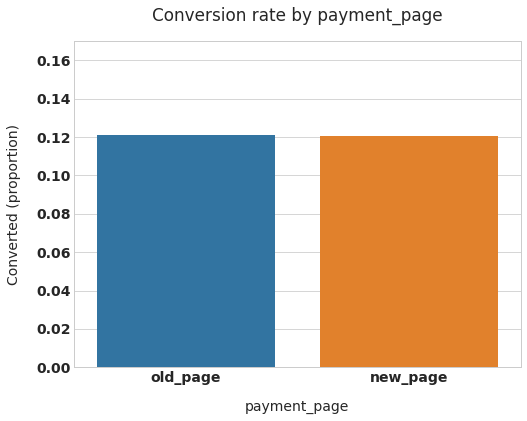

In [26]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['payment_page'], y=ab_test['is_convert'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by payment_page', pad=20)
plt.xlabel('payment_page', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

Tingkat konversi untuk payment_page sangat dekat. Perhatikan juga bahwa rasio konversi grup `kontrol` lebih tinggi dari yang kita harapkan. Tingkat konversi (12,1% vs. 12,0%). 

Jadi... nilai kelompok `kontrol` lebih tinggi. **Apakah perbedaan ini *signifikan secara statistik***?

 ## 4. Testing the hypothesis

In [28]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [30]:
control_results = ab_test[ab_test['payment_page'] == 'old_page']['is_convert']
treatment_results = ab_test[ab_test['payment_page'] == 'new_page']['is_convert']

In [31]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.06
p-value: 0.949
ci 95% for control group: [0.115, 0.127]
ci 95% for treatment group: [0.114, 0.127]


# Analisa dan Kesimpulan
'''Karena $p$-value=0.949 kami di atas $\alpha$=0,05 kami, kami tidak dapat menolak hipotesis nol $H_0$, 
yang berarti bahwa desain baru kami tidak berkinerja secara signifikan dibandingkan tampilan lama.'''

1. confidence interval control group hanya berkisar antara 11,5% - 12,7%
2. confidence interval treatment group 11,4% - 12,7% lebih rendah dari control group

Kesimpulannya, desain lama berpontensi mengalami penurunan kinerja sampai 11,7% dan treatment group perlu disesuaikan sampai mendapatkan target yang diharapkan yaitu 14%. 